In [62]:
!nvidia-smi

Tue Aug  3 12:13:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |   2645MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34
import os

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 32

# Praparing Images

In [65]:
os.listdir('../input/dogs-vs-cats-redux-kernels-edition')

['sample_submission.csv', 'train.zip', 'test.zip']

*We can not make a good use of test data here, since they have not been labled. SO, we are going ahead by val set*

In [66]:
import zipfile

os.makedirs('./data', exist_ok=True)
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = './data/train'
test_dir = './data/test'
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('./data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('./data')

In [67]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))   
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"There are {len(train_list)} train images. ")
print(f"There are {len(test_list)} test images. ")

There are 25000 train images. 
There are 12500 test images. 


To be faster in development stage you can reduce the number of using images

In [68]:
# train_list=train_list[0:2000]
# test_list=test_list[0:1000]

In [69]:
train_list[0].split('/')[-1].split('.')[0]

'cat'

In [70]:
int(train_list[0].split('/')[-1].split('.')[1])

6981

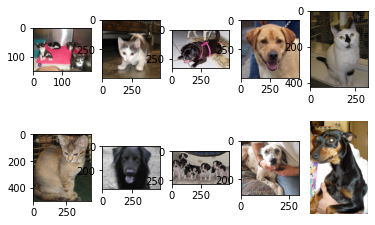

In [71]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

random_idx = np.random.randint(1,len(train_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

# Creating Datasets and Dataloaders

In [72]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [73]:
from PIL import Image

class CatDog_dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0     
        return img_transformed,label

In [74]:
# Data
transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

In [75]:
trainset = CatDog_dataset(train_list, transform=transform_train)
testset  = CatDog_dataset(test_list, transform=transform_test)
valset   = CatDog_dataset(val_list, transform=transform_test)

In [76]:
trainloader = torch.utils.data.DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

In [77]:
print(len(trainset), len(trainloader))
print(len(valset), len(valloader))
print(len(testset), len(testloader))

20000 625
5000 157
12500 391


# Building models

In [78]:
# class CustomNet(nn.Module):
#     def __init__(self):
#         super(Cnn,self).__init__()
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#             )
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
        
#         self.fc1 = nn.Linear(3*3*64,10)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(10,2)   # 2 is number of calss
#         self.relu = nn.ReLU()
        
        
#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0),-1)
#         out = self.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out

In [79]:
net = CustomNet()
net = resnet18()
net.fc = nn.Linear(512, 2)  # we have only 2 classes
net = net.to(device)

In [80]:
# net

In [81]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000
count_parameters(net)

11.177538

# Structuring to train

In [82]:
criterion = nn.CrossEntropyLoss()

In [83]:
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # we need scheduler.step() in train method

In [84]:
# FOUND_LR = 1e-3

# params = [
#           {'params': net.conv1.parameters(), 'lr': FOUND_LR / 10},
#           {'params': net.bn1.parameters(), 'lr': FOUND_LR / 10},
#           {'params': net.layer1.parameters(), 'lr': FOUND_LR / 8},
#           {'params': net.layer2.parameters(), 'lr': FOUND_LR / 6},
#           {'params': net.layer3.parameters(), 'lr': FOUND_LR / 4},
#           {'params': net.layer4.parameters(), 'lr': FOUND_LR / 2},
#           {'params': net.fc.parameters()}
#          ]

# optimizer = optim.Adam(params, lr = FOUND_LR)

Check everything is working well in one batch

In [85]:
batch = next(iter(trainloader))
data = batch[0]
lable = batch[1]
# print(data)
# print(lable)

In [86]:
y = net(batch[0].to(device))

In [87]:
criterion(y, batch[1].to(device))

tensor(0.6692, device='cuda:0', grad_fn=<NllLossBackward>)

# Train

In [88]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [89]:
import time
import sys
import torchmetrics


def train(epoch):
    net.train()
    loss_total = AverageMeter()
    accuracy = torchmetrics.Accuracy().cuda()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_total.update(loss)
        accuracy(outputs.softmax(dim=-1), targets)
    acc = accuracy.compute()
    print(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
    
    loss_total = AverageMeter()
    accuracy = torchmetrics.Accuracy().cuda()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss_total.update(loss)
            accuracy(outputs.softmax(dim=-1), targets)
        acc = accuracy.compute()
        print(f'Val:  Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')      
       # Save checkpoint
        if epoch%10==0: checkpoint.save(accuracy.compute(), 'ckpt', epoch=epoch)
        
class Checkpoint(object):
    def __init__(self):
        self.best_acc = 0.
        self.folder = 'chekpoint'
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, filename, epoch=-1):
        if acc > best_acc:
            print('Saving checkpoint...\n')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), filename + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [96]:
checkpoint = Checkpoint()
start, end = 0, 100
for epoch in range(start, end):
    train(epoch)

# Test
if we had the correct labels for test data, we could calculate the acc and loss of them


In [ ]:
# def test():
#     net.eval()
#     loss_total = AverageMeter()
#     accuracy_test = torchmetrics.Accuracy().cuda()
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(testloader):
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = net(inputs)
#             loss = criterion(outputs, targets)
#             loss_total.update(loss)
#             accuracy_test(outputs.softmax(dim=-1), targets)
#         acc = accuracy_test.compute()
#         print(f'Test: Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
#         print()


# test()

In [91]:
def test():
    dog_probs = []
    net.eval()
    with torch.no_grad():
        for data, fileid in testloader:
            data = data.to(device)
            preds = net(data)
            preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
            dog_probs += list(zip(list(fileid), preds_list))
            dog_probs.sort(key = lambda x : int(x[0]))
            idx = list(map(lambda x: x[0],dog_probs))
            prob = list(map(lambda x: x[1],dog_probs))
    return idx,prob

# Make and Save Submission

In [92]:
import pandas as pd
idx,prob=test()
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)

# show results

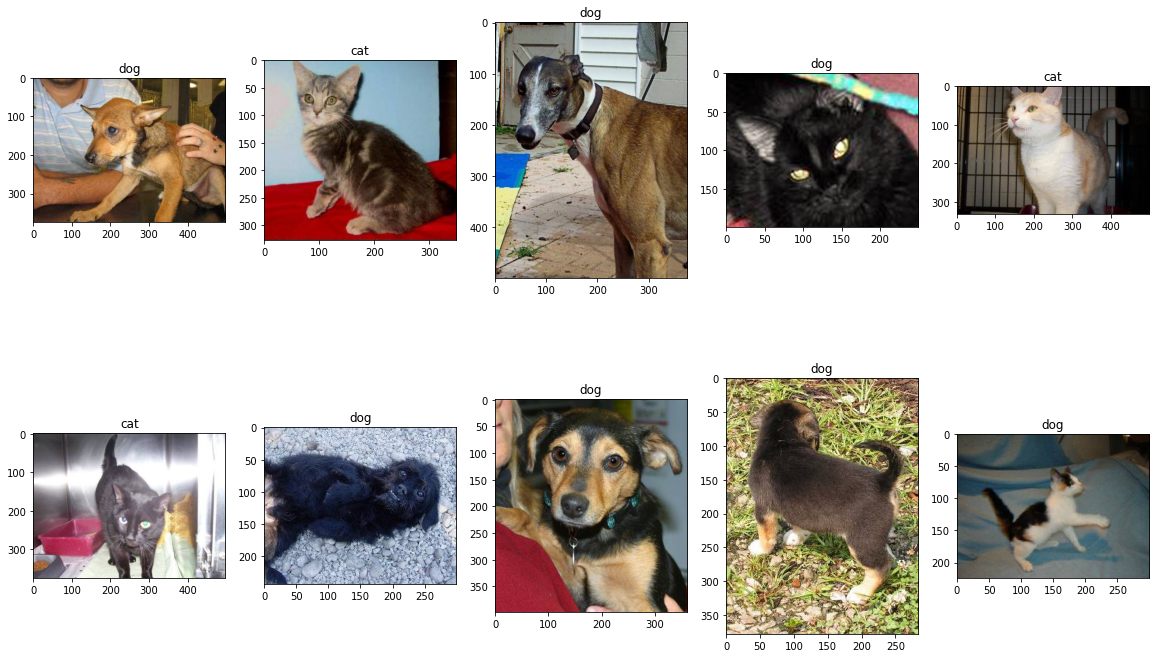

In [94]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)